# Create the GT image

In [9]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dir_path = '/home/nus/Downloads/sar_ground_truth/images/'

filenames = []
for filename in os.listdir(dir_path):
    if filename.endswith('.png'):
        filenames.append(os.path.join(dir_path, filename))

print(len(filenames))

29


In [ ]:
imgs = [np.array(Image.open(fn)) for fn in filenames]

In [8]:
gt = np.stack(imgs, axis=0).mean(axis=0)

gt.shape

(429, 611)

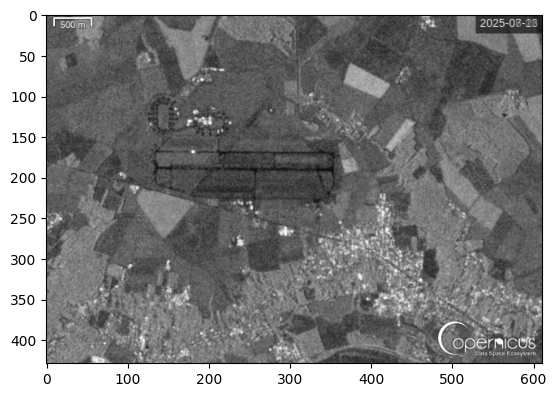

In [10]:
plt.imshow(gt, cmap='gray')

In [25]:
path_opt = "/home/nus/Downloads/sar_ground_truth/opt.png"

opt = np.array(Image.open(path_opt))[...,:3]
opt.shape

(708, 1007, 3)

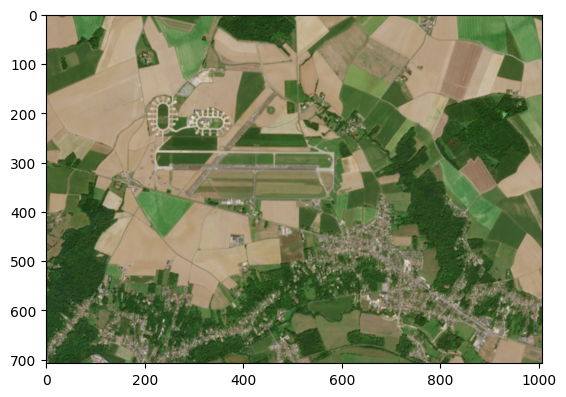

In [26]:
plt.imshow(opt)

In [30]:
# reshape to opt shape
gt_reshape = Image.fromarray(gt).resize((opt.shape[1], opt.shape[0]))
gt_reshape = np.array(gt_reshape)
gt_reshape.shape

(708, 1007)

(np.float64(-0.5), np.float64(1006.5), np.float64(707.5), np.float64(-0.5))

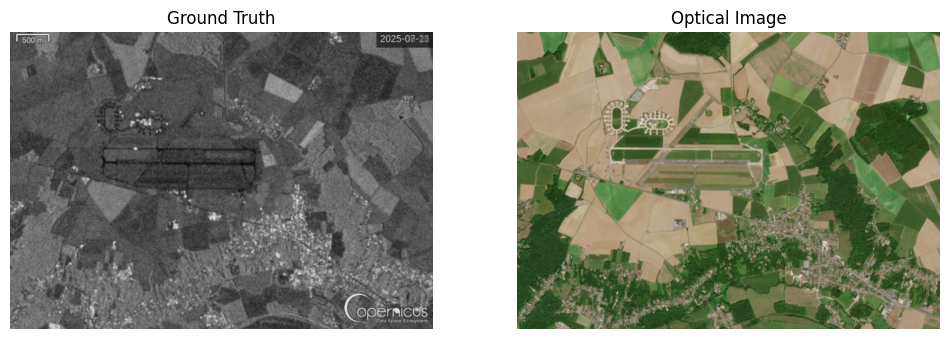

In [31]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Ground Truth')
plt.imshow(gt_reshape, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Optical Image')
plt.imshow(opt)
plt.axis('off')

In [32]:
sar_noise = imgs[0]

sar_noise = Image.fromarray(sar_noise).resize((opt.shape[1], opt.shape[0]))
sar_noise = np.array(sar_noise)
sar_noise.shape

(708, 1007)

(np.float64(-0.5), np.float64(1006.5), np.float64(707.5), np.float64(-0.5))

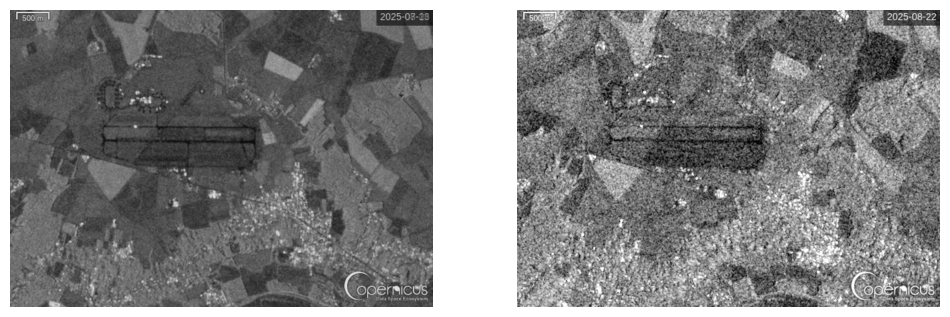

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(gt_reshape, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sar_noise, cmap='gray')
plt.axis('off')

In [34]:
crop_coords = (100, 100, 400, 400)  # (left, upper, right, lower)

gt_crop = gt_reshape[crop_coords[1]:crop_coords[3], crop_coords[0]:crop_coords[2]]
sar_crop = sar_noise[crop_coords[1]:crop_coords[3], crop_coords[0]:crop_coords[2]]
opt_crop = opt[crop_coords[1]:crop_coords[3], crop_coords[0]:crop_coords[2], :]

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

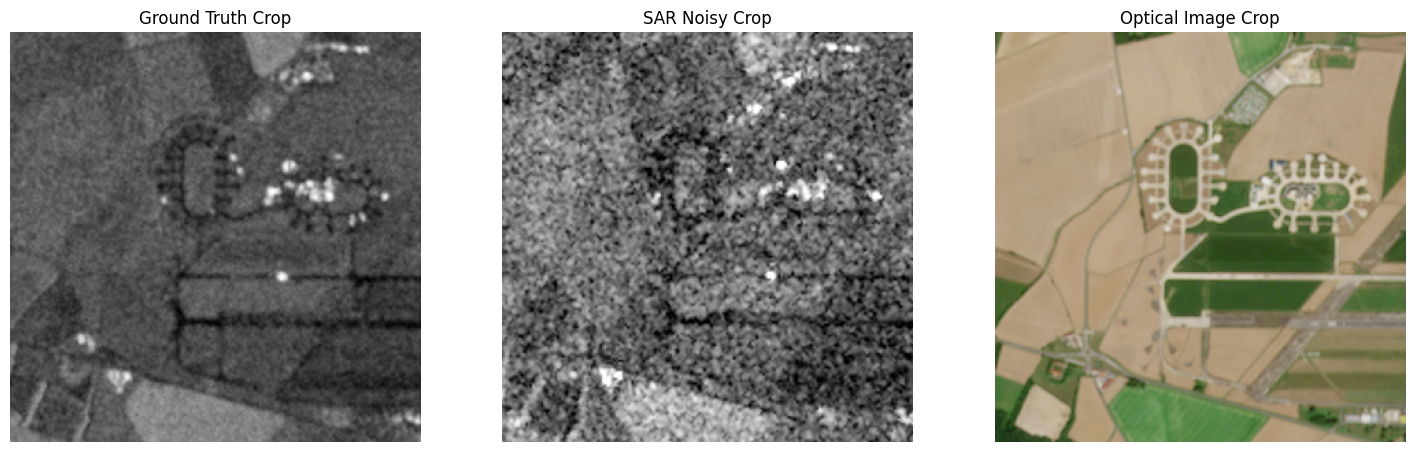

In [35]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.title('Ground Truth Crop')
plt.imshow(gt_crop, cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.title('SAR Noisy Crop')
plt.imshow(sar_crop, cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.title('Optical Image Crop')
plt.imshow(opt_crop)
plt.axis('off')

In [38]:
from scripts.despeckle import SARDespeckling
from scripts.texture_descriptor import rgb2gray, rgb2lab
import jax
import jax.numpy as jnp

print(jax.devices())

[cuda(id=0)]


In [60]:
sar_despeckling = SARDespeckling()

guide = opt_crop.mean(axis=-1)[..., None] / 255.0
noisy = sar_crop[..., None] / 255.0  # Normalize to [0, 1]

opt_gray = guide
sar = noisy

print(sar.shape, opt_gray.shape)

(300, 300, 1) (300, 300, 1)


In [65]:
params_texture_descriptor = {
    'opt': opt_gray,
    'radius': 7,
}

S = sar_despeckling._step1_compute_texture_descriptor(**params_texture_descriptor)

INFO:root:Computing texture descriptor...
INFO:root:Texture descriptor computed in 0.03 seconds.


In [120]:
params_mubf = {
    'target': S,
    'guides': [opt_gray, sar],  # (H, W, 1)
    'sigma_spatial': 5,
    'sigma_guides': [0.001, 0.001],
    'alpha': 5,
    'n_iterations': 50,
    'n_blocks': 5
}

S_mubf = sar_despeckling._step2_filter_texture_descriptor(**params_mubf)

INFO:root:Filtering texture descriptor with MUBF...
Iterations: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]
INFO:root:Texture descriptor filtering completed in 20.96 seconds.


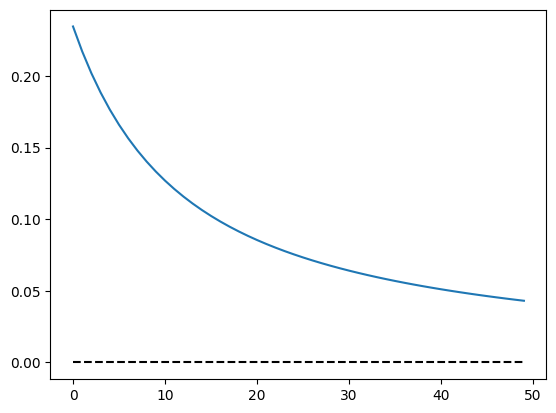

In [121]:
plt.plot(sar_despeckling.error)
plt.plot(np.arange(len(sar_despeckling.error)), np.zeros_like(sar_despeckling.error), 'k--')

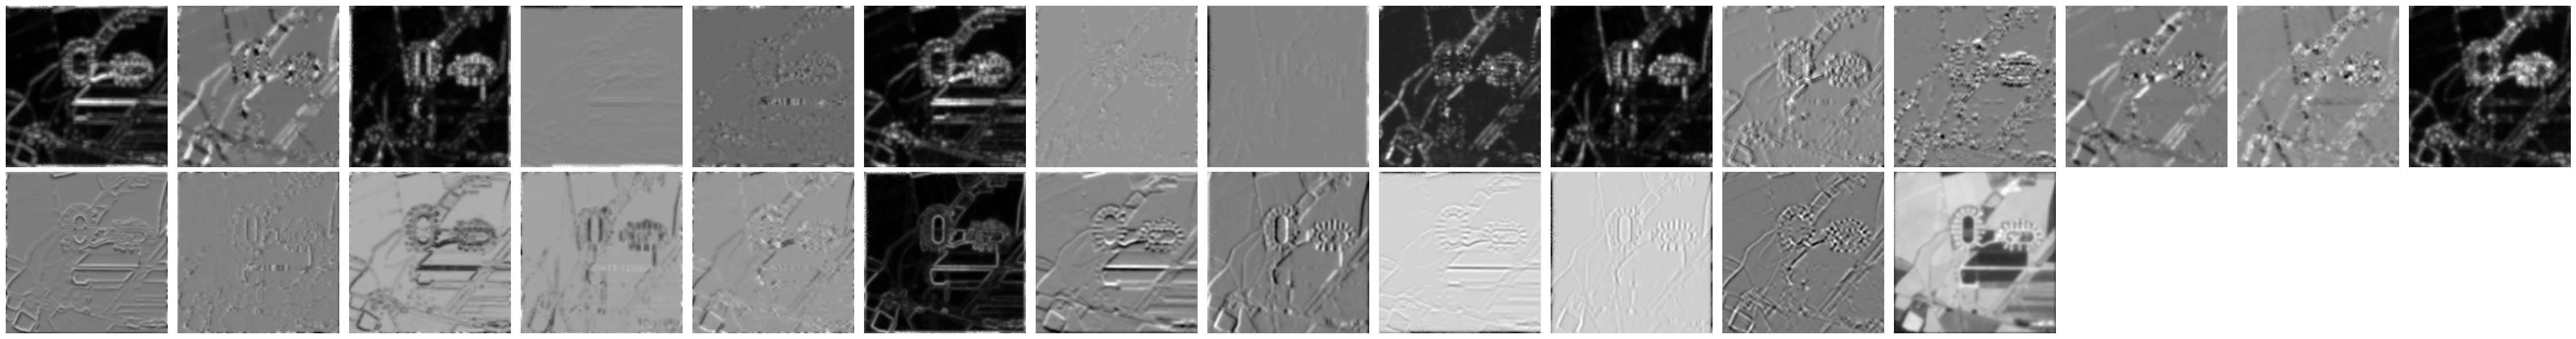

In [122]:
D = S_mubf.shape[-1]

N = 15  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S_mubf[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

In [123]:
params_despeckling = {
    "sar": sar,
    "descriptor": S_mubf,
    "sigma_distance": 0.02,
    "radius_despeckling": 15,
    "n_blocks": 10
}

sar_filtered = sar_despeckling._step3_despeckle(**params_despeckling)

INFO:root:Despeckling SAR image...
Despeckling: 100%|██████████| 100/100 [00:00<00:00, 110.15block/s]
INFO:root:Despeckling completed in 0.91 seconds.


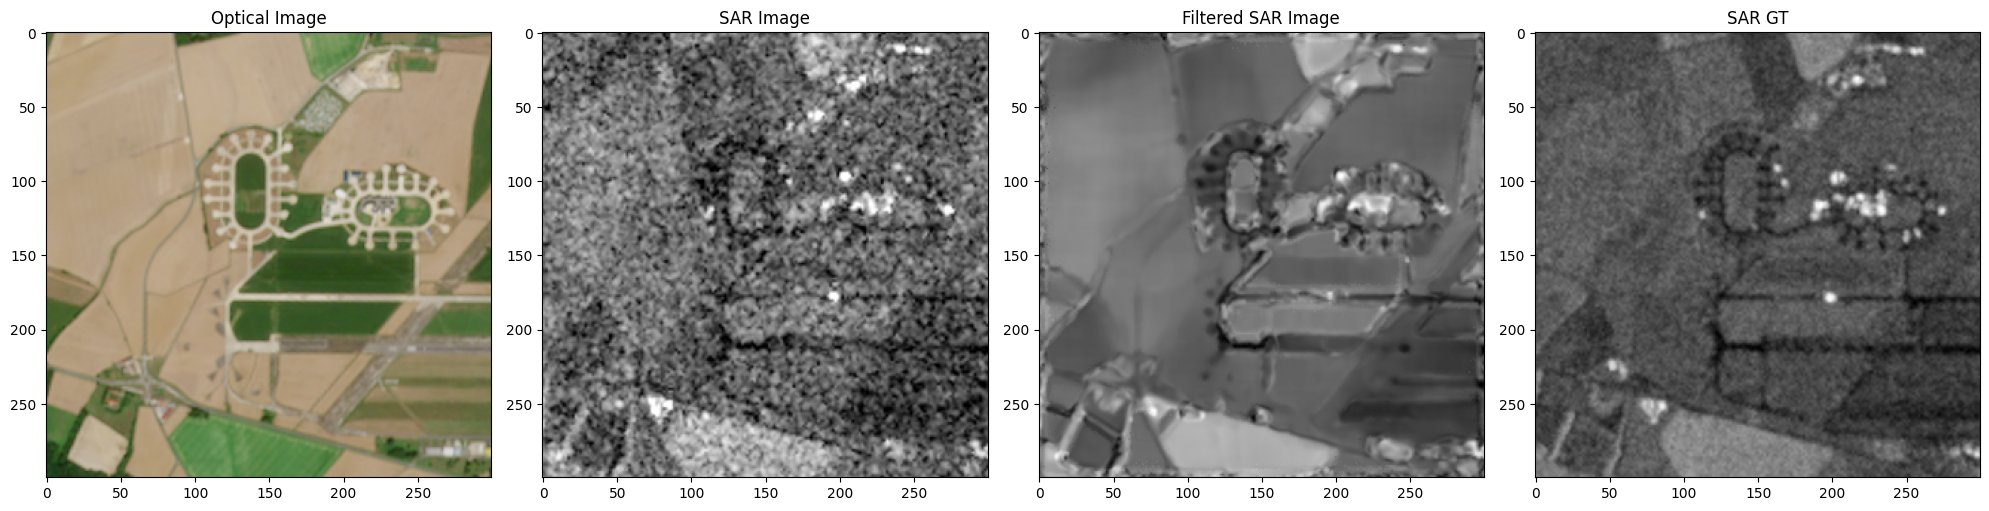

In [124]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(opt_crop)
plt.title('Optical Image')
plt.subplot(1, 4, 2)
plt.imshow(sar, cmap='gray')
plt.title('SAR Image')
plt.subplot(1, 4, 3)
plt.imshow(sar_filtered, cmap='gray')
plt.title('Filtered SAR Image')
plt.subplot(1, 4, 4)
plt.imshow(gt_crop, cmap='gray')
plt.title('SAR GT')
plt.tight_layout()
# plt.savefig(f'/home/nus/Downloads/{name}.png', dpi=300)